## Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import string

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, plot_confusion_matrix, balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.base import BaseEstimator, TransformerMixin

from textblob import TextBlob
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline, make_pipeline
!pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, FunctionTransformer 

#from pickle import dumps
from pickle import load
!pip install dill
from dill import dumps as dp
from dill import loads as ld 
from cloudpickle import dump
import joblib

import warnings
warnings.filterwarnings('ignore')

## Import the dataset

In [6]:
#!pip install matplotlib==3.4

In [7]:
text_data = pd.read_excel('hotel_reviews.xlsx')
text_data.head(20)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0
5,love monaco staff husband stayed hotel crazy w...,5.0
6,"cozy stay rainy city, husband spent 7 nights m...",5.0
7,"excellent staff, housekeeping quality hotel ch...",4.0
8,"hotel stayed hotel monaco cruise, rooms genero...",5.0
9,excellent stayed hotel monaco past w/e delight...,5.0


## EDA 

In [8]:
# Checking the size of dataset
text_data.shape

(20491, 2)

In [9]:
#Summarizing the overall dataset
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  20491 non-null  object 
 1   Rating  20491 non-null  float64
dtypes: float64(1), object(1)
memory usage: 320.3+ KB


In [10]:
#Checking the null values in dataset
text_data.isnull().sum()

Review    0
Rating    0
dtype: int64

In [11]:
#Checking the duplicate values
text_data.duplicated().sum()

0

In [12]:
#Statistical description of data (reviews)
text_data.describe(include='O')

,Review
count,20491
unique,20491
top,nice hotel expensive parking got good deal sta...
freq,1


In [13]:
#Statistical description of data (ratings)
text_data.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [14]:
#Unique rating values 
sorted(text_data['Rating'].unique())

[1.0, 2.0, 3.0, 4.0, 5.0]

In [15]:
#Count of Ratings
text_data['Rating'].value_counts()

5.0    9054
4.0    6039
3.0    2184
2.0    1793
1.0    1421
Name: Rating, dtype: int64

In [16]:
#Converting the ratings column from float to int
text_data['Rating'] = text_data['Rating'].astype('int')

In [17]:
#Count of ratings after change in data-type
text_data['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

### Data Visualization 

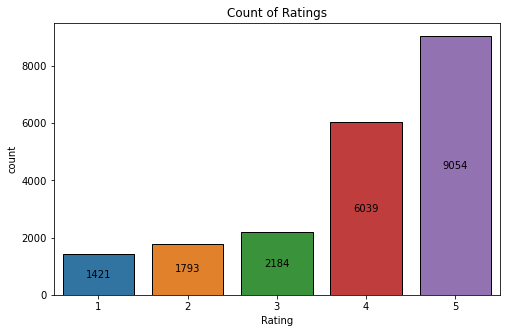

In [18]:
#Visualizing the unique values of ratings
plt.figure(figsize=(8,5))

ax = sns.countplot(data = text_data , x = 'Rating', edgecolor='black', linewidth=1)

for i in ax.containers:
    ax.bar_label(i, label_type='center')
    
plt.title('Count of Ratings')
plt.show()

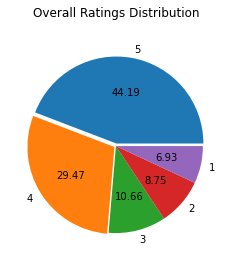

In [19]:
#Checking the total contribution of all ratings
plt.pie(text_data['Rating'].value_counts(), autopct='%0.2f', labels=['5', '4', '3', '2', '1'], explode=[0.03, 0.02, 0.0, 0.0, 0.0])
plt.title('Overall Ratings Distribution\n')
plt.show()

In [20]:
#Checking the most used words from reviews & plotting it using WordCloud
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          #background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

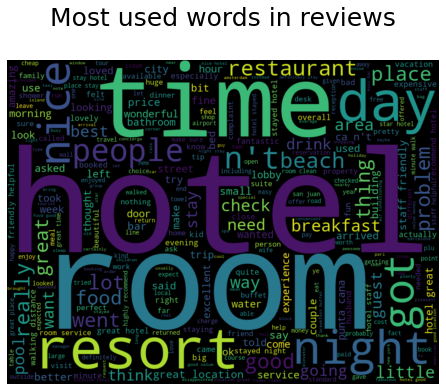

In [21]:
#Plotting the wordcloud on original data for all ratings
wordCloud_generator(data=text_data['Review'], title="Most used words in reviews\n")

In [22]:
#Checking the most used words from reviews & plotting it using WordCloud
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          #background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

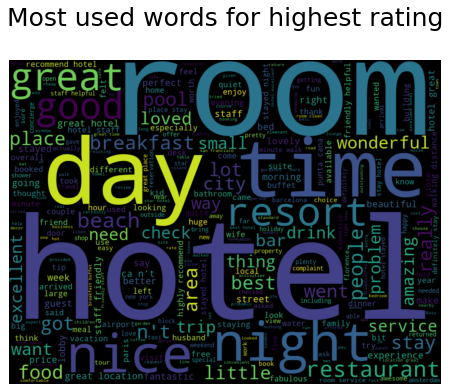

In [23]:
#Plotting the wordcloud on original data for all highest rating (5)
wordCloud_generator(data=text_data[text_data['Rating']==5]['Review'], title="Most used words for highest rating\n")

In [24]:
#Checking the most used words from reviews & plotting it using WordCloud
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          #background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

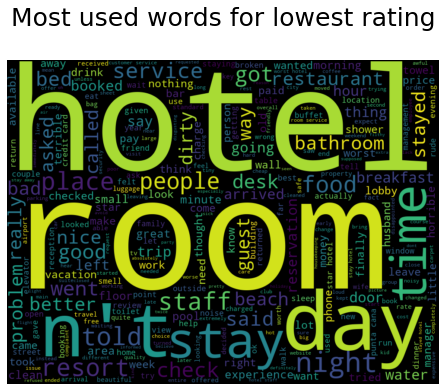

In [25]:
#Plotting the wordcloud on original data for all lowest rating (1)
wordCloud_generator(data=text_data[text_data['Rating']==1]['Review'],title="Most used words for lowest rating\n")

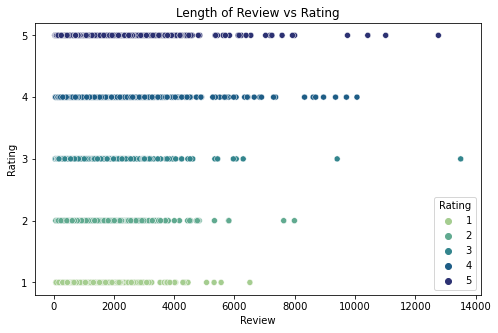

In [26]:
#Checking the length of words in a review for all the rating
plt.figure(figsize=(8,5))
sns.scatterplot(x=text_data['Review'].apply(len), y=text_data['Rating'], data=text_data, palette='crest', hue='Rating')
plt.title('Length of Review vs Rating')
plt.yticks([1,2,3,4,5])
plt.show()

In [27]:
#Making a copy of the original dataset
text_data1 = text_data.copy()

In [28]:
#Preview of dataset
text_data1

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rakesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rakesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rakesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Rakesh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
#Object Instantiation
stop_words = nltk.corpus.stopwords.words('english')
stpw = ENGLISH_STOP_WORDS
wnl = WordNetLemmatizer()

In [34]:
# defined a function for cleaning all reviews in the data set

def clean_text(text):
    
    text = re.sub(r'\w*\d\w*', '', str(text)).strip() #Removing numeric attached with words and return only alpha 
    
    text = re.sub("[\d]+", "", str(text))  # Removing the strings which contains unnecessary digits in data
    
    text = re.sub(r"won\'t", "will not", str(text))      # Replace contraction words
    text = re.sub(r"can\'t", "can not", str(text))      # Replace contraction words
    text = re.sub(r"ca n\'t", "can not", str(text))      # Replace contraction words
    text = re.sub(r"wo n\'t", "will not", str(text))      # Replace contraction words
    text = re.sub(r"\'t've", " not have", str(text))     # Replace contraction words
    text = re.sub(r"\'d've", " would have", str(text))   # Replace contraction words
    text = re.sub(r"\'cause", " because", str(text))     # Replace contraction words
    
    text = re.sub(r"n\'t", " not", str(text))     # Replace contraction words
    text = re.sub(r"\'re", " are", str(text))     # Replace contraction words
    text = re.sub(r"\'s", " is", str(text))       # Replace contraction words
    text = re.sub(r"\'d", " would", str(text))    # Replace contraction words
    text = re.sub(r"\'ll", " will", str(text))    # Replace contraction words
    text = re.sub(r"\'t", " not", str(text))      # Replace contraction words
    text = re.sub(r"\'ve", " have", str(text))    # Replace contraction words
    text = re.sub(r"\'m", " am", str(text))       # Replace contraction words

    text = re.sub(r"n\'t", " not", str(text))     # Replace contraction words
    text = re.sub(r"\'re", " are", str(text))     # Replace contraction words
    text = re.sub(r"\'s", " is", str(text))       # Replace contraction words
    text = re.sub(r"\'d", " would", str(text))    # Replace contraction words
    text = re.sub(r"\'ll", " will", str(text))    # Replace contraction words
    text = re.sub(r"\'t", " not", str(text))      # Replace contraction words
    text = re.sub(r"\'ve", " have", str(text))    # Replace contraction words
    text = re.sub(r"\'m", " am", str(text))       # Replace contraction words
    
    text = re.sub(r'[^\w\s]', " ", str(text))    # Removing white spaces and returning only alpha characters
    
    text = text.translate(str.maketrans('','',string.punctuation)) # Remove Punctuations
    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text)) # Remove Punctuations
    
    text = ' '.join( [w for w in text.split() if len(w)>1] ) # Removing an unnecessary single character from sentences
    
    text = text.split() #Splitting each word
    
    text = " ".join([word for word in text if word.lower().strip() not in stop_words]) #Removing stopwords, white spaces, making words lower and joining into text
    
    text = text.split() # Splitting each word
    
    text = " ".join([word for word in text if word not in stpw]) # Removing extra stopwords if any
    
    text = nltk.word_tokenize(text)  # Tokenising each words 
       
    text = " ".join([wnl.lemmatize(w, 'v') for w in text])  # Applying Lemmatization

    text = ' '.join(dict.fromkeys(text.split())) #Remove duplicate words from a sentence
    
    return text

In [35]:
#Testing purpose - reviewing the original reviews before text preprocessing
text_data1['Review'][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

In [36]:
#Testing purpose - Checking length of original data
len(text_data1['Review'][2])

1427

In [37]:
#Testing purpose - reviewing the original reviews after text preprocessing
clean_text(text_data1['Review'][2])

'nice room experience hotel monaco seattle good level positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeep staffnegatives ac unit malfunction stay desk disorganize miss separate wakeup call concierge busy hard touch provide guidance special request tv use ipod sound dock non function decide book night weekend choice rest party fill comparison spend larger square footage great soak tub whirlpool jet shower arrange car service price tip reasonable driver wait arrival checkin easy downside pick person jacuzi bath accessories salt bubble get check voucher bottle champagne gesture fish impression huge open space felt big far away chore change channel break disappoint morning way ask thermostat say degrees warm try cover face bright blue light keep drop maintainence come look tell play settings happy digital box work happen later nap forget yep facilities surprise sell amenities relax water go'

In [38]:
#Testing purpose - Checking length of preprocessed data
len(clean_text(text_data1['Review'][2]))

934

In [39]:
#Applying the clean_text function on entire dataset
text_data1['Fully_Clean_Text'] = text_data1['Review'].apply(lambda x: clean_text(x))
text_data1

,Review,Rating,Fully_Clean_Text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive park get good deal stay a...
1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay go seahawk game awesome downfall vi...
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best keep secret time stay charm star beat inc...
20487,great location price view hotel great quick pl...,4,great location price view hotel quick place si...
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outside desk staff particu...
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruin vacation open sept guests wee...


In [40]:
#Testing purpose - Verifying the sample review
len(text_data1['Fully_Clean_Text'][2])

934

In [41]:
text_data1['Length'] = text_data1['Review'].apply(len)
new_length = text_data1['Length'].sum()

In [42]:
text_data1['Lengths'] = text_data1['Fully_Clean_Text'].apply(len)
new_lengths = text_data1['Lengths'].sum()

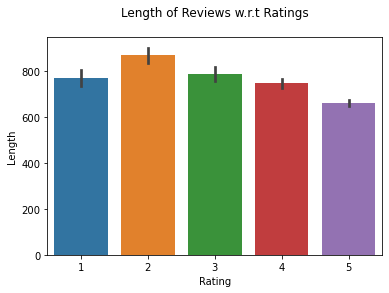

In [43]:
#Visualizing the length of reviews
sns.barplot(data=text_data1, x='Rating', y='Length')
plt.title('Length of Reviews w.r.t Ratings\n')
plt.show()

In [44]:
#Comparing the length of reviews before & after text preprocessing
print('\033[1m'+ "Total Length of Review Comparison" + '\033[0m')
print('=======================================')
print("Before Text Preprocessing : {}".format(new_length))
print('---------------------------------------')
print("After Text Preprocessing  :{}".format(new_lengths))
print('=======================================')

Total Length of Review Comparison
Before Text Preprocessing : 14861007
---------------------------------------
After Text Preprocessing  :10397957


## Sentiment Analysis


In [45]:
##Object Instantiation
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rakesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
#Defining a function for Sentiment Analysis
def fetch_sentiment_using_SIA(text):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = sia.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [47]:
#Applying the VADER function to entire data
text_data1['SIA_Vader'] = text_data1.Fully_Clean_Text.apply(lambda x: fetch_sentiment_using_SIA(x))

In [48]:
#Reviewing the data
text_data1[['Fully_Clean_Text', 'Rating', 'SIA_Vader']]

,Fully_Clean_Text,Rating,SIA_Vader
0,nice hotel expensive park get good deal stay a...,4,pos
1,ok special charge diamond member hilton decide...,2,pos
2,nice room experience hotel monaco seattle good...,3,pos
3,unique great stay wonderful time hotel monaco ...,5,pos
4,great stay go seahawk game awesome downfall vi...,5,pos
...,...,...,...
20486,best keep secret time stay charm star beat inc...,5,pos
20487,great location price view hotel quick place si...,4,pos
20488,ok look nice modern outside desk staff particu...,2,pos
20489,hotel theft ruin vacation open sept guests wee...,1,pos


In [49]:
#Drawn a positive sample for testing the sentiment
text_data1['Fully_Clean_Text'][20487]

'great location price view hotel quick place sight directly street space needle downtown tram science center mall amenities nice indoor pool kid secure underground park garage restaurant room size couple families recommend visit like tostay near'

In [50]:
#Testing the sample
sia.polarity_scores(text_data1['Fully_Clean_Text'][20487])

{'neg': 0.0, 'neu': 0.684, 'pos': 0.316, 'compound': 0.9231}

In [51]:
#Drawn a negative sample for testing the sentiment
text_data1['Fully_Clean_Text'][20489]

'hotel theft ruin vacation open sept guests week happy stumble scout hotels apt stay book gobcn comment post unexpectedly cancel arrival stick place la merce festival barcelona biggest year like try time square new eve vacancies ready towel straight factory wash pilling shower entire sleep proper blanket comforter arrive get chilly night give fleece throw supply sister ciutat lime green colour scheme red black white spare cold drawback double bed single adjoin bother linens separately fish sheet order couple fall lie middle hard firm quality foam pillow best qualities location close las ramblas hear street noise somewhat walkable attractions bari gottic design clean stylish room construction things cement drippings scrap linoleum floor importantly safe securely bolt travel cash come korea unfavorable exchange rate prefer use canadian visa card unsure korean credit work overseas turn husband carry moneybelt life petty problems witness mass humanity wallet separate person blink eye saw s

In [52]:
#Testing the sample
sia.polarity_scores(text_data1['Fully_Clean_Text'][20489])

{'neg': 0.161, 'neu': 0.617, 'pos': 0.222, 'compound': 0.9884}

Total Count of Sentiments

pos    95.095408
neg     4.904592
Name: SIA_Vader, dtype: float64 



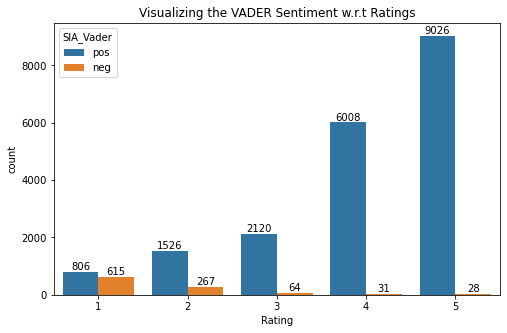

In [53]:
#Visualizing the Vader Sentiment Analysis
plt.figure(figsize=(8,5))

plt.title("Visualizing the VADER Sentiment w.r.t Ratings")

ax = sns.countplot(data = text_data1 , x = 'Rating', hue = 'SIA_Vader')

for i in ax.containers:
    ax.bar_label(i,)
        
print('Total Count of Sentiments\n')

print(text_data1['SIA_Vader'].value_counts(['SIA_Vader'])*100, '\n')

In [54]:
#Applying the TextBlob to entire data
text_data1['TxtB_Polarity'] = text_data1['Fully_Clean_Text'].apply(lambda x: TextBlob(x).sentiment[0])

In [55]:
#Reviewing the data
text_data1[['Fully_Clean_Text', 'Rating', 'TxtB_Polarity']]

,Fully_Clean_Text,Rating,TxtB_Polarity
0,nice hotel expensive park get good deal stay a...,4,0.157805
1,ok special charge diamond member hilton decide...,2,0.184212
2,nice room experience hotel monaco seattle good...,3,0.300569
3,unique great stay wonderful time hotel monaco ...,5,0.468056
4,great stay go seahawk game awesome downfall vi...,5,0.445000
...,...,...,...
20486,best keep secret time stay charm star beat inc...,5,0.200152
20487,great location price view hotel quick place si...,4,0.319048
20488,ok look nice modern outside desk staff particu...,2,0.193365
20489,hotel theft ruin vacation open sept guests wee...,1,0.144561


In [56]:
#Drawn a positive sample for testing the sentiment
txt = TextBlob(text_data1['Fully_Clean_Text'][20487])

In [57]:
#Testing the sample
txt.polarity

0.3190476190476191

In [58]:
#Testing the sample
txt.sentiment_assessments

Sentiment(polarity=0.3190476190476191, subjectivity=0.5357142857142857, assessments=[(['great'], 0.8, 0.75, None), (['quick'], 0.3333333333333333, 0.5, None), (['directly'], 0.1, 0.4, None), (['center'], -0.1, 0.1, None), (['nice'], 0.6, 1.0, None), (['secure'], 0.4, 0.6, None), (['near'], 0.1, 0.4, None)])

In [59]:
#Drawn a negative sample for testing the sentiment
txt2 = TextBlob(text_data1['Fully_Clean_Text'][20489])

In [60]:
#Testing the sample
txt2.polarity

0.14456093674843673

In [61]:
#Testing the sample
txt2.sentiment_assessments

Sentiment(polarity=0.14456093674843673, subjectivity=0.5580271965688632, assessments=[(['open'], 0.0, 0.5, None), (['happy'], 0.8, 1.0, None), (['stumble'], -0.05, 0.1, None), (['apt'], 0.6, 1.0, None), (['unexpectedly'], 0.1, 1.0, None), (['new'], 0.13636363636363635, 0.45454545454545453, None), (['ready'], 0.2, 0.5, None), (['straight'], 0.2, 0.4, None), (['entire'], 0.0, 0.625, None), (['proper'], 0.0, 0.1, None), (['chilly'], -0.6, 0.9, None), (['green'], -0.2, 0.3, None), (['red'], 0.0, 0.0, None), (['black'], -0.16666666666666666, 0.43333333333333335, None), (['white'], 0.0, 0.0, None), (['cold'], -0.6, 1.0, None), (['double'], 0.0, 0.0, None), (['single'], -0.07142857142857142, 0.21428571428571427, None), (['middle'], 0.0, 0.0, None), (['hard'], -0.2916666666666667, 0.5416666666666666, None), (['firm'], -0.2, 0.4, None), (['best'], 1.0, 0.3, None), (['clean'], 0.3666666666666667, 0.7000000000000001, None), (['stylish'], 0.5, 1.0, None), (['importantly', 'safe'], 0.5, 0.5, None),

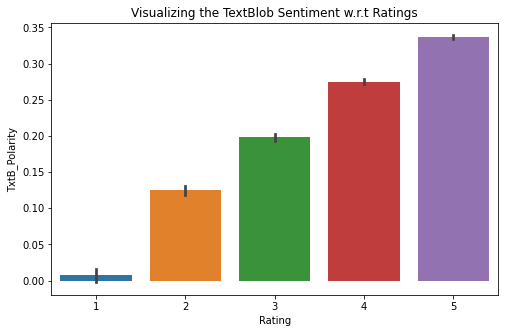

In [62]:
#Visualizing the TextBlob Sentiment Analysis
plt.figure(figsize=(8,5))

ax = sns.barplot(data= text_data1, x = 'Rating', y = 'TxtB_Polarity')

plt.title("Visualizing the TextBlob Sentiment w.r.t Ratings")

plt.show()

In [63]:
!pip install afinn

In [64]:
# Emotion Lexicon - Affin
from afinn import Afinn

In [65]:
#Object Instantiation
afn = Afinn()

In [66]:
#Drawn a negative sample for testing the sentiment
nn = text_data1['Fully_Clean_Text'][20490]

In [67]:
#Testing the negative sample
afn.score(nn)

14.0

In [68]:
#Drawn a positive sample for testing the sentiment
pp = text_data1['Fully_Clean_Text'][20487]

In [69]:
#Testing the positive sample
afn.score(pp)

12.0

In [70]:
#Applying afinn to dataset
text_data1['Afinn_score'] = text_data1['Fully_Clean_Text'].apply(lambda x: afn.score(x))

In [71]:
#Reviewing the data
text_data1[['Fully_Clean_Text',  'Rating', 'Afinn_score']]

,Fully_Clean_Text,Rating,Afinn_score
0,nice hotel expensive park get good deal stay a...,4,14.0
1,ok special charge diamond member hilton decide...,2,29.0
2,nice room experience hotel monaco seattle good...,3,10.0
3,unique great stay wonderful time hotel monaco ...,5,22.0
4,great stay go seahawk game awesome downfall vi...,5,18.0
...,...,...,...
20486,best keep secret time stay charm star beat inc...,5,20.0
20487,great location price view hotel quick place si...,4,12.0
20488,ok look nice modern outside desk staff particu...,2,8.0
20489,hotel theft ruin vacation open sept guests wee...,1,10.0


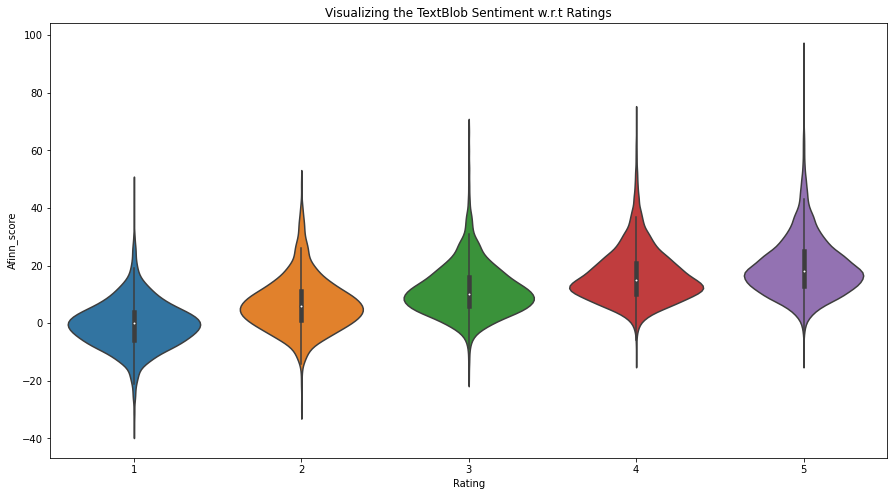

In [72]:
#Visualizing the Afinn Sentiment Analysis

plt.figure(figsize=(15,8))

ax = sns.violinplot(data= text_data1, x = 'Rating', y = 'Afinn_score')

plt.title("Visualizing the TextBlob Sentiment w.r.t Ratings")

plt.show()

In [73]:
#Defining a function for Sentiment Analysis
def condition(x):
    if x>=20:
        return "Pos"
    else:
        return 'Neg'

In [74]:
#Applying condition on Afinn score 
text_data1['Affin_Sent'] = text_data1['Afinn_score'].apply(condition)

In [75]:
#Reviewing the data
text_data1[['Fully_Clean_Text',  'Rating', 'Afinn_score', 'Affin_Sent']]

,Fully_Clean_Text,Rating,Afinn_score,Affin_Sent
0,nice hotel expensive park get good deal stay a...,4,14.0,Neg
1,ok special charge diamond member hilton decide...,2,29.0,Pos
2,nice room experience hotel monaco seattle good...,3,10.0,Neg
3,unique great stay wonderful time hotel monaco ...,5,22.0,Pos
4,great stay go seahawk game awesome downfall vi...,5,18.0,Neg
...,...,...,...,...
20486,best keep secret time stay charm star beat inc...,5,20.0,Pos
20487,great location price view hotel quick place si...,4,12.0,Neg
20488,ok look nice modern outside desk staff particu...,2,8.0,Neg
20489,hotel theft ruin vacation open sept guests wee...,1,10.0,Neg


In [76]:
#Count of Afinn sentiment
text_data1['Affin_Sent'].value_counts()

Neg    14196
Pos     6295
Name: Affin_Sent, dtype: int64

In [77]:
#Analysing the data for rating = 1 with lowest score
text_data1[text_data1['Rating']==1].min()['Afinn_score']

-36.0

In [78]:
#Analysing the data for rating = 1 with highest score
text_data1[text_data1['Rating']==1].max()['Afinn_score']

47.0

In [79]:
#Analysing the data for rating = 5 with lowest score
text_data1[text_data1['Rating']==5].min()['Afinn_score']

-12.0

In [80]:
#Analysing the data for rating = 5 with lowest score
text_data1[text_data1['Rating']==5].max()['Afinn_score']

94.0

### Model Based - Machine Learning

#### Naive Bayes & Logistic Regression based Sentiment Analysis

##### Label encoding

In [81]:
#Converting the ratings into two labels of Positive & Negative

text_data1['Target'] = text_data1['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [82]:
#Reference for original data for encoded value
text_data1.head()

,Review,Rating,Fully_Clean_Text,Length,Lengths,SIA_Vader,TxtB_Polarity,Afinn_score,Affin_Sent,Target
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive park get good deal stay a...,593,438,pos,0.157805,14.0,Neg,1
1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...,1689,1030,pos,0.184212,29.0,Pos,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,1427,934,pos,0.300569,10.0,Neg,0
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,600,445,pos,0.468056,22.0,Pos,1
4,"great stay great stay, went seahawk game aweso...",5,great stay go seahawk game awesome downfall vi...,1281,891,pos,0.445000,18.0,Neg,1


In [83]:
#Re-checking the dtype for all columns
text_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Review            20491 non-null  object 
 1   Rating            20491 non-null  int32  
 2   Fully_Clean_Text  20491 non-null  object 
 3   Length            20491 non-null  int64  
 4   Lengths           20491 non-null  int64  
 5   SIA_Vader         20491 non-null  object 
 6   TxtB_Polarity     20491 non-null  float64
 7   Afinn_score       20491 non-null  float64
 8   Affin_Sent        20491 non-null  object 
 9   Target            20491 non-null  int64  
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 1.5+ MB


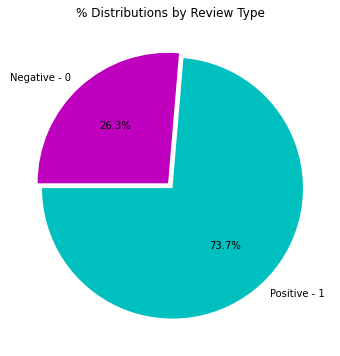

In [84]:
#Checking the ratings
plt.figure(figsize=(12,6))

g = plt.pie(round(text_data1.Target.value_counts(normalize=True)*100,2),explode=(0.025,0.025), 
            labels=['Positive - 1', 'Negative - 0'], colors=["c","m"],
            autopct="%1.1f%%", startangle=180)

plt.title("% Distributions by Review Type")

plt.show()

###### Note:
* From above visual, we can say that most of the reviews are positive and only around 26% are negative reviews.  

##### Feature Extraction
* TF - IDF

In [85]:
#TF-IDF features
vectorizer = TfidfVectorizer()

##### Model Building

* Building Models with default parameters & imbalanced data

In [86]:
#Splitting the variables into features & target
X = text_data1['Fully_Clean_Text']
y = text_data1['Target']

In [87]:
#Checking the count of target variable
text_data1['Target'].value_counts()

1    15093
0     5398
Name: Target, dtype: int64

In [88]:
#Segregating data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, shuffle=True, stratify=y)

In [89]:
#Applying the TF-IDF vectorizer to train data
X_train = vectorizer.fit_transform(X_train)

In [90]:
#Applying the TF-IDF vectorizer to test data
X_test = vectorizer.transform(X_test)

In [91]:
#Building the different classification models with default parameters
lr_mod  = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced')
nb_mod  = MultinomialNB()

##### Model Training with above base models

In [92]:
%%time
lr_mod.fit(X_train, y_train)
nb_mod.fit(X_train, y_train)

CPU times: total: 953 ms
Wall time: 790 ms


MultinomialNB()

##### Model Testing & Evaluation

In [93]:
%%time
y_pred_lr  = lr_mod.predict(X_test)
y_pred_nb = nb_mod.predict(X_test)

CPU times: total: 31.2 ms
Wall time: 11 ms


##### Analysing the model performance & accuracy

In [94]:
#Checking the count of test variable - target
y_test.value_counts()

1    4528
0    1620
Name: Target, dtype: int64

In [95]:
#Checking the accuracy for all models
cc  = [y_pred_lr, y_pred_nb]
mod = ['Logistic Regression', 'Naive Bayes']

print('Accuracy Scores for all models','\n')

for i,j in zip(cc, mod):
    print('===========================')
    print(j, ':', balanced_accuracy_score(y_test, i).round(2))
    print('===========================', '\n')

Accuracy Scores for all models 

Logistic Regression : 0.87

Naive Bayes : 0.54



Confusion Matrix for all models


Logistic Regression


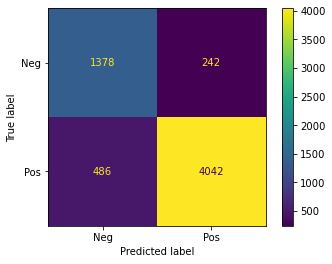



Naive Bayes


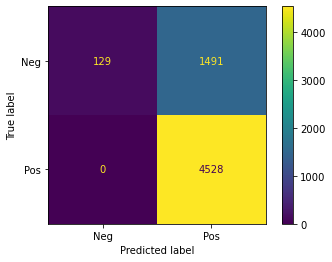

In [96]:
#Plotting Confusion Matrix for all models
dd  = [lr_mod, nb_mod]
mod = ['Logistic Regression', 'Naive Bayes']

print('Confusion Matrix for all models')

for i,j in zip(dd, mod):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test, y_test, display_labels= ['Neg', 'Pos'])   
    plt.show()

In [97]:
#Classification Report for all models
cc  = [y_pred_lr, y_pred_nb]
mod = ['Logistic Regression', 'Naive Bayes']

print('Classification Report for all models','\n')

for i,j in zip(cc, mod):
    print('========================================================')
    print(j,'\n\n' , classification_report(y_test, i))
    print('========================================================', '\n')

Classification Report for all models 

Logistic Regression 

               precision    recall  f1-score   support

           0       0.74      0.85      0.79      1620
           1       0.94      0.89      0.92      4528

    accuracy                           0.88      6148
   macro avg       0.84      0.87      0.85      6148
weighted avg       0.89      0.88      0.88      6148


Naive Bayes 

               precision    recall  f1-score   support

           0       1.00      0.08      0.15      1620
           1       0.75      1.00      0.86      4528

    accuracy                           0.76      6148
   macro avg       0.88      0.54      0.50      6148
weighted avg       0.82      0.76      0.67      6148




In [98]:
#Transforming the data to X & y
X = vectorizer.fit_transform(X)
y = y

In [99]:
#Object Instantiation
sm = SMOTE(random_state=0)

In [100]:
#Resampling the dataset with smote
X_res, y_res = sm.fit_resample(X, y)

In [101]:
#Rechecking the count of target variable after smote
print('X_res after resampling shape : ' , X_res.shape)
print('y_res after resampling shape : ' , y_res.shape, '\n')
print(y_res.value_counts())

X_res after resampling shape :  (30186, 43131)
y_res after resampling shape :  (30186,) 

1    15093
0    15093
Name: Target, dtype: int64


##### Building models with balanced data (smote_resampled data)

In [102]:
#Splitting data into training and testing dataset with 80:20 ratio
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=0, test_size=0.35, stratify=y_res)

In [103]:
#Checking the size of features
X_train_res.shape, X_test_res.shape

((19620, 43131), (10566, 43131))

##### Model Building with default parameters & smote_resampled data

In [104]:
lr_mod2  =LogisticRegression(random_state=0, max_iter=1000)
nb_mod2  = MultinomialNB()

##### Model Training

In [105]:
%%time
lr_mod2.fit(X_train_res, y_train_res)
nb_mod2.fit(X_train_res, y_train_res)

CPU times: total: 1.66 s
Wall time: 1.18 s


MultinomialNB()

##### Model Testing & Evaluation

In [106]:
%%time
y_pred_lr2  = lr_mod2.predict(X_test_res)
y_pred_nb2  = nb_mod2.predict(X_test_res)

CPU times: total: 31.2 ms
Wall time: 33 ms


In [107]:
#Checking the accuracy for all models
cc  = [y_pred_lr2, y_pred_nb2]
mod = ['Logistic Regression', 'Naive Bayes']

print('Accuracy Scores for all models','\n')

for i,j in zip(cc, mod):
    print('===========================')
    print(j, ':', balanced_accuracy_score(y_test_res, i).round(2))
    print('===========================', '\n')

Accuracy Scores for all models 

Logistic Regression : 0.91

Naive Bayes : 0.88



Confusion Matrix for all models


Logistic Regression


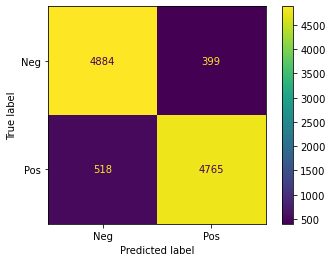



Naive Bayes


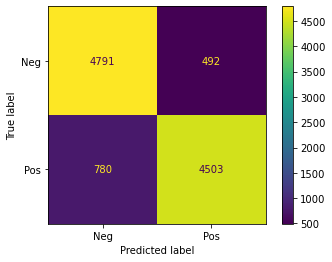

In [108]:
#Plotting Confusion Matrix for all models
mm = ['Logistic Regression', 'Naive Bayes']
dd = [lr_mod2 ,nb_mod2]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_res, y_test_res, display_labels= ['Neg', 'Pos'])   
    plt.show()

In [109]:
#Classification Report for all models
cc = [y_pred_lr2, y_pred_nb2]
mm = ['Logistic Regression', 'Naive Bayes']

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_res, i))
    print('======================================================', '\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      5283
           1       0.92      0.90      0.91      5283

    accuracy                           0.91     10566
   macro avg       0.91      0.91      0.91     10566
weighted avg       0.91      0.91      0.91     10566


Naive Bayes 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      5283
           1       0.90      0.85      0.88      5283

    accuracy                           0.88     10566
   macro avg       0.88      0.88      0.88     10566
weighted avg       0.88      0.88      0.88     10566




In [110]:
#Comparing the models imbalance & model smote_balance data with balanced accuracy score
mod_comp = pd.DataFrame(index=mm, columns=['Model1', 'Model2'], data={'Model1': [balanced_accuracy_score(y_test ,y_pred_lr).round(2), balanced_accuracy_score(y_test ,y_pred_nb).round(2)], 
                                                                      'Model2': [balanced_accuracy_score(y_test_res ,y_pred_lr2).round(2), balanced_accuracy_score(y_test_res ,y_pred_nb2).round(2)]
                                                                       })
mod_comp['%Change in Accuracy'] = (mod_comp['Model2'] - mod_comp['Model1'])*100
mod_comp.sort_values(by='Model2', ascending=False)

,Model1,Model2,%Change in Accuracy
Logistic Regression,0.87,0.91,4.0
Naive Bayes,0.54,0.88,34.0


In [111]:
#Object Instantiation
ad = ADASYN(random_state=0)

In [112]:
#Resampling the dataset with adasyn
X_ad, y_ad = ad.fit_resample(X, y)

In [113]:
#Rechecking the count of target variable after adasyn
print('X_res after resampling shape : ' , X_ad.shape)
print('y_res after resampling shape : ' , y_ad.shape, '\n')
print(y_ad.value_counts())

X_res after resampling shape :  (30105, 43131)
y_res after resampling shape :  (30105,) 

1    15093
0    15012
Name: Target, dtype: int64


##### Building models with balanced data (ADASYN)

In [114]:
#Splitting data into training and testing dataset with 80:20 ratio
X_train_ad, X_test_ad, y_train_ad, y_test_ad = train_test_split(X_ad, y_ad, random_state=0, test_size=0.35, stratify=y_ad)

In [115]:
#Checking the size of features
X_train_ad.shape, X_test_ad.shape

((19568, 43131), (10537, 43131))

##### Model Building with default parameters & adasyn_resampled data

In [116]:
lr_mod3  = LogisticRegression(random_state=0, max_iter=1000)
nb_mod3  = MultinomialNB()

##### Model Training

In [117]:
%%time
lr_mod3.fit(X_train_ad, y_train_ad)
nb_mod3.fit(X_train_ad, y_train_ad)

CPU times: total: 3.2 s
Wall time: 2.26 s


MultinomialNB()

##### Model Testing & Evaluation

In [118]:
%%time
y_pred_lr3  = lr_mod3.predict(X_test_ad)
y_pred_nb3  = nb_mod3.predict(X_test_ad)

CPU times: total: 15.6 ms
Wall time: 25 ms


In [119]:
#Testing the roc-auc score for all models
cc = [y_pred_lr3, y_pred_nb3]
mm = ['Logistic Regression', 'Naive Bayes']

print('ROC-AUC score for all models')

for i,j in zip(cc, mm):
    print('\n==============================')
    print(j, ':', balanced_accuracy_score(y_test_ad, i).round(2))
    print('==============================', '\n')

ROC-AUC score for all models

Logistic Regression : 0.91


Naive Bayes : 0.88



Confusion Matrix for all models


Logistic Regression


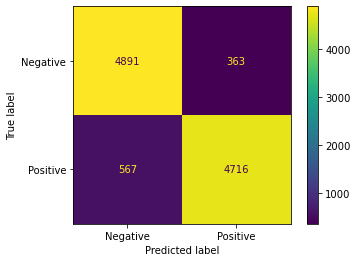



Naive Bayes


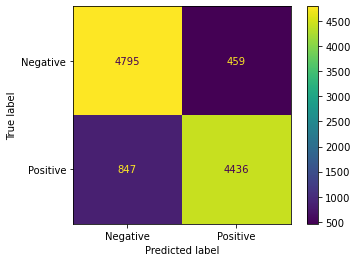

In [120]:
#Plotting Confusion Matrix for all models
mm = ['Logistic Regression', 'Naive Bayes']
dd = [lr_mod3, nb_mod3]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_ad, y_test_ad, display_labels= ['Negative', 'Positive'])   
    plt.show()

In [121]:
#Classification Report for all models
cc = [y_pred_lr3, y_pred_nb3]
mm = ['Logistic Regression', 'Naive Bayes']

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_ad, i))
    print('======================================================', '\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      5254
           1       0.93      0.89      0.91      5283

    accuracy                           0.91     10537
   macro avg       0.91      0.91      0.91     10537
weighted avg       0.91      0.91      0.91     10537


Naive Bayes 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      5254
           1       0.91      0.84      0.87      5283

    accuracy                           0.88     10537
   macro avg       0.88      0.88      0.88     10537
weighted avg       0.88      0.88      0.88     10537




In [122]:
#Comparing the models imbalance & model adasyn_balance data with balanced accuracy score
mod_comp = pd.DataFrame(index=mm, columns=['Model1', 'Model2'], data={'Model1': [balanced_accuracy_score(y_test ,y_pred_lr).round(2), balanced_accuracy_score(y_test ,y_pred_nb).round(2)], 
                                                                      'Model2': [balanced_accuracy_score(y_test_ad ,y_pred_lr3).round(2), balanced_accuracy_score(y_test_ad ,y_pred_nb3).round(2)]
                                                                       })
mod_comp['%Change in Accuracy'] = mod_comp['Model2'] - mod_comp['Model1']
mod_comp.sort_values(by='Model2', ascending=False)

,Model1,Model2,%Change in Accuracy
Logistic Regression,0.87,0.91,0.04
Naive Bayes,0.54,0.88,0.34


In [123]:
#Object Instantiation
rs = RandomUnderSampler(random_state=0)

In [124]:
#Resampling the dataset with random-under-sampler
X_rs, y_rs = rs.fit_resample(X, y)

In [125]:
#Rechecking the count of target variable after random-under-sampler
print('X_res after resampling shape : ' , X_rs.shape)
print('y_res after resampling shape : ' , y_rs.shape, '\n')
print(y_rs.value_counts())

X_res after resampling shape :  (10796, 43131)
y_res after resampling shape :  (10796,) 

0    5398
1    5398
Name: Target, dtype: int64


##### Building models with Random Under sampling

In [126]:
#Splitting data into training and testing dataset with 80:20 ratio
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, y_rs, random_state=0, test_size=0.35, stratify=y_rs)

In [127]:
#Checking the size of features
X_train_rs.shape, X_test_rs.shape

((7017, 43131), (3779, 43131))

##### Model Building with default parameters & random-under-sampler_resampled data

In [128]:
lr_mod4  = LogisticRegression(random_state=0, max_iter=1000)
nb_mod4  = MultinomialNB()

##### Model Training

In [129]:
%%time
lr_mod4.fit(X_train_rs, y_train_rs)
nb_mod4.fit(X_train_rs, y_train_rs)

CPU times: total: 672 ms
Wall time: 450 ms


MultinomialNB()

##### Model Testing & Evaluation

In [130]:
%%time
y_pred_lr4  = lr_mod4.predict(X_test_rs)
y_pred_nb4  = nb_mod4.predict(X_test_rs)

CPU times: total: 15.6 ms
Wall time: 8 ms


In [131]:
#Testing the balanced accuracy for all models
cc = [y_pred_lr4, y_pred_nb4]
mm = ['Logistic Regression', 'Naive Bayes']

print('Balanced Accuracy score for all models')

for i,j in zip(cc, mm):
    print('\n==============================')
    print(j, ':', balanced_accuracy_score(y_test_rs, i).round(2))
    print('==============================', '\n')

Balanced Accuracy score for all models

Logistic Regression : 0.87


Naive Bayes : 0.84



Confusion Matrix for all models


Logistic Regression


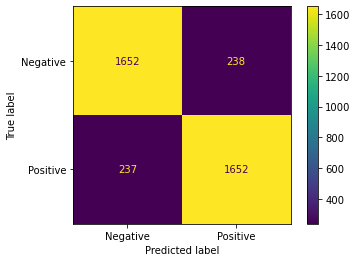



Naive Bayes


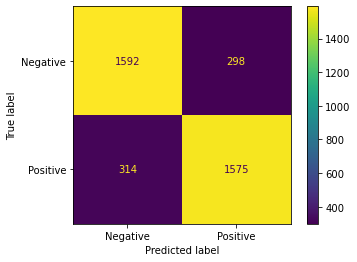

In [132]:
#Plotting Confusion Matrix for all models
mm = ['Logistic Regression', 'Naive Bayes']
dd = [lr_mod4, nb_mod4]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_rs, y_test_rs, display_labels= ['Negative', 'Positive'])   
    plt.show()

In [133]:
#Classification Report for all models
cc = [y_pred_lr4, y_pred_nb4]
mm = ['Logistic Regression', 'Naive Bayes']

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_rs, i))
    print('======================================================', '\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      1890
           1       0.87      0.87      0.87      1889

    accuracy                           0.87      3779
   macro avg       0.87      0.87      0.87      3779
weighted avg       0.87      0.87      0.87      3779


Naive Bayes 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1890
           1       0.84      0.83      0.84      1889

    accuracy                           0.84      3779
   macro avg       0.84      0.84      0.84      3779
weighted avg       0.84      0.84      0.84      3779




In [134]:
#Comparing the models imbalance & model random-under-sampler_balance data with balanced accuracy score
mod_comp = pd.DataFrame(index=mm, columns=['Model1', 'Model2'], data={'Model1': [balanced_accuracy_score(y_test ,y_pred_lr).round(2), balanced_accuracy_score(y_test ,y_pred_nb).round(2)], 
                                                                      'Model2': [balanced_accuracy_score(y_test_rs ,y_pred_lr4).round(2), balanced_accuracy_score(y_test_rs ,y_pred_nb4).round(2)]
                                                                       })
mod_comp['%Change in Accuracy'] = (mod_comp['Model2'] - mod_comp['Model1'])*100
mod_comp.sort_values(by='Model2', ascending=False)

,Model1,Model2,%Change in Accuracy
Logistic Regression,0.87,0.87,0.0
Naive Bayes,0.54,0.84,30.0


In [135]:
#Object Instantiation
tl = TomekLinks()

In [136]:
#Resampling the dataset with smote-tomek
X_tl, y_tl = tl.fit_resample(X, y)

In [137]:
##Rechecking the count of target variable after tomek
print('X_res after resampling shape : ' , X_tl.shape)
print('y_res after resampling shape : ' , y_tl.shape, '\n')
print(y_tl.value_counts())

X_res after resampling shape :  (20143, 43131)
y_res after resampling shape :  (20143,) 

1    14745
0     5398
Name: Target, dtype: int64


##### Building models with balanced data (SMOTE + TOMEK)

In [138]:
#Splitting data into training and testing dataset with 80:20 ratio
X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(X_tl, y_tl, random_state=0, test_size=0.35, stratify=y_tl)

In [139]:
#Checking the size of features
X_train_tl.shape, X_test_tl.shape

((13092, 43131), (7051, 43131))

##### Model Building with default parameters & smote-tomek_resampled data

In [140]:
lr_mod5  = LogisticRegression(random_state=0, max_iter=1000)
nb_mod5  = MultinomialNB()

##### Model Training

In [141]:
%%time
lr_mod5.fit(X_train_tl, y_train_tl)
nb_mod5.fit(X_train_tl, y_train_tl)

CPU times: total: 2.31 s
Wall time: 1.78 s


MultinomialNB()

##### Model Testing & Evaluation

In [142]:
%%time
y_pred_lr5  = lr_mod5.predict(X_test_tl)
y_pred_nb5  = nb_mod5.predict(X_test_tl)

CPU times: total: 31.2 ms
Wall time: 14 ms


In [143]:
#Testing the accuracy score for all models
cc = [y_pred_lr5, y_pred_nb5]
mm = ['Logistic Regression', 'Naive Bayes']

print('Balanced Accuracy score for all models')

for i,j in zip(cc, mm):
    print('\n==============================')
    print(j, ':', balanced_accuracy_score(y_test_tl, i).round(2))
    print('==============================', '\n')

Balanced Accuracy score for all models

Logistic Regression : 0.83


Naive Bayes : 0.52



Confusion Matrix for all models


Logistic Regression


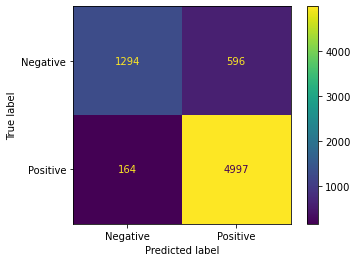



Naive Bayes


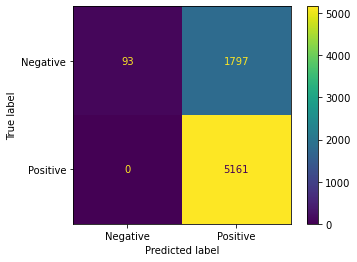

In [144]:
#Plotting Confusion Matrix for all models
mm = ['Logistic Regression', 'Naive Bayes']
dd = [lr_mod5, nb_mod5]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_tl, y_test_tl, display_labels= ['Negative', 'Positive'])   
    plt.show()

In [145]:
#Classification Report for all models
cc = [y_pred_lr5, y_pred_nb5]
mm = ['Logistic Regression', 'Naive Bayes']

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_tl, i))
    print('======================================================', '\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.89      0.68      0.77      1890
           1       0.89      0.97      0.93      5161

    accuracy                           0.89      7051
   macro avg       0.89      0.83      0.85      7051
weighted avg       0.89      0.89      0.89      7051


Naive Bayes 
               precision    recall  f1-score   support

           0       1.00      0.05      0.09      1890
           1       0.74      1.00      0.85      5161

    accuracy                           0.75      7051
   macro avg       0.87      0.52      0.47      7051
weighted avg       0.81      0.75      0.65      7051




In [146]:
#Comparing the models imbalance & model smote_balance data with balanced accuracy score
mod_comp = pd.DataFrame(index=mm, columns=['Model1', 'Model2'], data={'Model1': [balanced_accuracy_score(y_test ,y_pred_lr).round(2), balanced_accuracy_score(y_test ,y_pred_nb).round(2)], 
                                                                      'Model2': [balanced_accuracy_score(y_test_tl ,y_pred_lr5).round(2), balanced_accuracy_score(y_test_tl ,y_pred_nb5).round(2)]
                                                                       })
mod_comp['%Change in Accuracy'] = (mod_comp['Model2'] - mod_comp['Model1'])*100
mod_comp.sort_values(by='Model2', ascending=False)

,Model1,Model2,%Change in Accuracy
Logistic Regression,0.87,0.83,-4.0
Naive Bayes,0.54,0.52,-2.0


### ML Model Stability & Performance

#### Cross Validation on original data

In [147]:
kf = KFold(n_splits=15, shuffle=True, random_state=0)

In [148]:
cross_val_score(lr_mod, X, y, cv=kf, scoring='accuracy').mean().round(3)*100

88.6

In [149]:
cross_val_score(lr_mod, X, y, cv=kf, scoring='accuracy').std().round(3)*100

1.0

In [150]:
cross_val_score(nb_mod, X, y, cv=kf, scoring='accuracy').mean().round(3)*100

76.5

In [151]:
cross_val_score(nb_mod, X, y, cv=kf, scoring='accuracy').std().round(3)*100

1.3

**The cross validation score is around 89% for Logistic Regression with 1% deviation, 77% for Naive Bayes model with 1.2% deviation on original dataset respectively.**

#### Cross Validation on smote data

In [152]:
cross_val_score(lr_mod2, X_res, y_res, cv=kf, scoring='accuracy').mean().round(3)*100

91.8

In [153]:
cross_val_score(lr_mod2, X_res, y_res, cv=kf, scoring='accuracy').std().round(3)*100

0.7000000000000001

In [154]:
cross_val_score(nb_mod2, X_res, y_res, cv=kf, scoring='accuracy').mean().round(3)*100

87.7

In [155]:
cross_val_score(nb_mod2, X_res, y_res, cv=kf, scoring='accuracy').std().round(3)*100

0.6

**The cross validation score is around 92% for Logistic Regression with 0.7 % deviation, 88% for Naive Bayes model with around 0.6 % deviation on smote resampled dataset respectively.**

# =============================================

***Let's, try building model using deep learning!!***

### Model Based - Deep Learning pretrained models

In [165]:
!pip install transformers
!pip install torch

In [167]:
#Import required libraries
from transformers import AutoTokenizer,pipeline,TFDistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification 
from transformers import DistilBertModel, DistilBertConfig, TFTrainer
from transformers import DistilBertTokenizer, TFPreTrainedModel
from scipy.special import softmax
import torch

In [168]:
#Model Building 
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
#tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
classifier1 = pipeline('sentiment-analysis', model=tf_model, tokenizer=tokenizer)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [169]:
#Model Evaluation
classifier1

In [170]:
#Testing the model - sarcastic sentence
classifier1('The bed was in such a good condition, I slept on the floor.')

[{'label': 'NEGATIVE', 'score': 0.9822930693626404}]

In [171]:
#Testing the model - sarcastic sentence
classifier1('the food will bring nausea and motion sickness; it was that deliciously sick.')

[{'label': 'NEGATIVE', 'score': 0.9583131074905396}]

In [172]:
#Testing the model - sarcastic sentence
classifier1('It was a fucking amazing experience!! Will definitely visit this hotel again.')

[{'label': 'POSITIVE', 'score': 0.9998341798782349}]

In [173]:
#Testing the model - negative sentence
classifier1('I am not feeling well.')

[{'label': 'NEGATIVE', 'score': 0.9997661709785461}]

In [174]:
#Saving the model
classifier1.save_pretrained("mod_tf")

## Building Pipeline 


In [175]:
def clean_text_frame(X):
    b = clean_text
    return X.applymap(b)  # the function "clean_text" currently in your class.

In [176]:
#Using the mapper to perform specific transformer to the features
m = DataFrameMapper([(['Review'], FunctionTransformer(func=clean_text_frame)),
                      
                    ], df_out=True, input_df=True)

In [177]:
#Construct the column transfomer
vectorizer1 = TfidfVectorizer()
column_transformer = ColumnTransformer(
    [('Tfidf1', vectorizer1, 'Review')],
    remainder='passthrough')

In [178]:
#Object Instantiation
mod = LogisticRegression(random_state=0, max_iter=1300)

mod1 = MultinomialNB()

sampling  = SMOTE(random_state=0)

In [179]:
#Making Pipeline for Logistic Regression
model = Pipeline([ ('Cleaning', m),
                  ('Tfidf', column_transformer), ('SMOTE', sampling), ('MODEL', mod)
                ])

In [180]:
#Reviewing the pipeline
model

Pipeline(steps=[('Cleaning',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['Review'],
                                            FunctionTransformer(func=<function clean_text_frame at 0x0000011F27A3F1F0>))],
                                 input_df=True)),
                ('Tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tfidf1', TfidfVectorizer(),
                                                  'Review')])),
                ('SMOTE', SMOTE(random_state=0)),
                ('MODEL', LogisticRegression(max_iter=1300, random_state=0))])

In [181]:
#Making Pipeline for Naive Bayes
model1 = Pipeline([ ('Cleaning', m),
                  ('Tfidf', column_transformer), ('SMOTE', sampling), ('MODEL', mod1)
                ])

In [182]:
#Reviewing the pipeline
model1

Pipeline(steps=[('Cleaning',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['Review'],
                                            FunctionTransformer(func=<function clean_text_frame at 0x0000011F27A3F1F0>))],
                                 input_df=True)),
                ('Tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tfidf1', TfidfVectorizer(),
                                                  'Review')])),
                ('SMOTE', SMOTE(random_state=0)), ('MODEL', MultinomialNB())])

## User Testing


In [183]:
#Making another copy of original data 
text_data2 = text_data.copy()

In [184]:
#Label encoding the target variable
text_data2['Rating'] = text_data2['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [185]:
#Reviewing the data after label encoding
text_data2.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,0
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1


In [186]:
#Picking up 20 random samples from the original data for testing
usx = text_data2.sample(n=20, random_state=12)
usx['Rating'].value_counts()

0    10
1    10
Name: Rating, dtype: int64

In [187]:
#Index values of samples
usix = usx['Rating'].index

In [188]:
#Splititing the collected samples for testing
X_t   = usx[['Review']]
y_t   = usx[['Rating']].values

In [189]:
X_t.shape, y_t.shape

((20, 1), (20, 1))

In [190]:
#Dropping the collected samples from original dataset so that model is not trained on it
text_data2 = text_data2.drop(index=usix).reset_index()
text_data2 = text_data2.drop('index', axis=1)

In [191]:
#Reviewing the data after dropping the test samples
text_data2

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,0
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1
...,...,...
20466,"best kept secret 3rd time staying charm, not 5...",1
20467,great location price view hotel great quick pl...,1
20468,"ok just looks nice modern outside, desk staff ...",0
20469,hotel theft ruined vacation hotel opened sept ...,0


In [192]:
#Splitting the original data for training the model
X_tr = text_data2[['Review']]
y_tr = text_data2[['Rating']].values

In [193]:
X_tr.head()

,Review
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso..."


In [194]:
y_tr

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [195]:
#Training the model using Logistic Regression
model.fit(X_tr, y_tr)

Pipeline(steps=[('Cleaning',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['Review'],
                                            FunctionTransformer(func=<function clean_text_frame at 0x0000011F27A3F1F0>))],
                                 input_df=True)),
                ('Tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tfidf1', TfidfVectorizer(),
                                                  'Review')])),
                ('SMOTE', SMOTE(random_state=0)),
                ('MODEL', LogisticRegression(max_iter=1300, random_state=0))])

In [196]:
#Predicting the test sample
model.predict(X_t)

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
      dtype=int64)

In [197]:
#Model performance score
model.score(X_t, y_t)

0.85

In [198]:
#Model Testing & Evaluation - Logistic Regression

print('Actual data:', '   ',y_t.flatten(), '\n')

print('Predicted data: ', model.predict(X_t))

Actual data:     [0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1] 

Predicted data:  [1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1]


In [199]:
#model1 = model.fit_resample(X, y)

In [200]:
#Training the model using Naive Bayes
model1.fit(X_tr, y_tr)

Pipeline(steps=[('Cleaning',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['Review'],
                                            FunctionTransformer(func=<function clean_text_frame at 0x0000011F27A3F1F0>))],
                                 input_df=True)),
                ('Tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tfidf1', TfidfVectorizer(),
                                                  'Review')])),
                ('SMOTE', SMOTE(random_state=0)), ('MODEL', MultinomialNB())])

In [201]:
#Predicting the test sample
model1.predict(X_t)

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
      dtype=int64)

In [202]:
#Model performance score
model1.score(X_t, y_t)

0.95

In [203]:
#Model Testing & Evaluation - Naive Bayes

print('Actual data:', '   ',y_t.flatten(), '\n')

print('Predicted data: ', model1.predict(X_t))

Actual data:     [0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1] 

Predicted data:  [0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1]


In [204]:
#Custom reviews for testing after saving model
tt = {'Review': ['The bed was in such a good condition, I slept on the floor.', 'the food will bring nausea and motion sickness; it was that delicious sick.', 'It was a fucking amazing experience!! Will definitely visit this hotel again.']}
t1 = pd.DataFrame(tt, index=[0,1,2])
t1

,Review
0,"The bed was in such a good condition, I slept ..."
1,the food will bring nausea and motion sickness...
2,It was a fucking amazing experience!! Will def...


In [205]:
#Saving a joblib model
joblib.dump(model1, 'joblib_model1')

['joblib_model1']

In [206]:
#Loading a joblib model
mj = joblib.load('joblib_model1')

In [207]:
#Predicting the model based on custom reviews
mj.predict(t1)

array([0, 0, 1], dtype=int64)

In [208]:
#Saving the model to file
dump(model1, open('hrsa_intelligence.joblib', 'wb'))

In [209]:
#Loading the file
ml = load(open('hrsa_intelligence.joblib', 'rb'))

In [210]:
#Running the file for testing & evaluating custom reviews
print('Predicted Values:', ml.predict(t1))

Predicted Values: [0 0 1]
